In [1]:
import sys, os
import re
import time
import tempfile
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
# set all needed paths
experiment_name = 'three_users'

# models, labels and images
models_path = 'models/finetuning-googlenet/'
labels_path = '../../../data/emanuela/activity-recognition/labels/'
images_path = '../../../data/emanuela/activity-recognition/images/NTCIR-Lifelog-256/'

experiment_models_path = models_path + experiment_name + '/'
experiment_labels_path = labels_path + experiment_name + '/'

# dataset paths
labels_dataset_path = labels_path + 'labels.txt'
train_dataset_path  = experiment_labels_path + 'train.txt'
val_dataset_path    = experiment_labels_path + 'val.txt'

# mean file path
mean_file_path = models_path + 'imagenet_mean.binaryproto'

# weights with which to start
googlenet_weights = 'models/weights-googlenet/bvlc_googlenet.caffemodel'

prototxt_path = models_path + 'train_val.prototxt'

# main files for the network
activities_net_desc = {
    'solver':    models_path + 'solver.prototxt',
    'train_val': models_path + 'train_val.prototxt',
    'weights':   experiment_models_path + 'result.caffemodel',
    'snapshot':  experiment_models_path + 'result_snapshot'
}

In [3]:
# create and modify some files and directories
if not os.path.exists(experiment_models_path):
    os.makedirs(experiment_models_path)
    
# set right paths in prototxt file
train_path_index = 15
val_path_index = 35

with open(prototxt_path) as prototxt:
    lines = prototxt.readlines()
   
lines[train_path_index] = re.sub(r'"(.*?)"', '"'+ train_dataset_path +'"', lines[train_path_index])
lines[val_path_index] = re.sub(r'"(.*?)"', '"'+ val_dataset_path +'"', lines[val_path_index])

with open(prototxt_path, 'w') as prototxt:
    prototxt.write("".join(lines))

In [4]:
# load images and labels

def format_line(line, path_to_images):
    line = line.split(' ')
    activity = line[-1]
    image_name = ' '.join(line[:-1])
    
    return [path_to_images + '/' + image_name, activity]

# get all labels
labels_set = list(np.loadtxt(labels_dataset_path, str, delimiter='\n'))

# get train images and labels
train_dataset = [ format_line(line, images_path)
    for line in list(np.loadtxt(train_dataset_path, str, delimiter='\n'))
]

train_paths, train_labels = zip(*[(path, int(label)) for path, label in train_dataset])

# get validation images and labels
val_dataset = [ format_line(line, images_path) 
    for line in list(np.loadtxt(val_dataset_path, str, delimiter='\n'))
]

val_paths, val_labels = zip(*[(path, int(label)) for path, label in val_dataset])

NUM_ACTIVITIES_LABELS = len(labels_set)
num_train_images = len(train_paths)
num_train_labels = len(set(train_labels))
num_val_images = len(val_paths)
num_val_labels = len(set(val_labels))
    
print 'Loaded labels:', str(len(labels_set)), '\n\n', ', '.join(labels_set)
print '\nTraining pictures:', num_train_images, '\nTraining labels:', num_train_labels
print '\nValidation pictures:', num_val_images, '\nValidation labels:', num_val_labels

Loaded labels: 21 

public transport, driving, walking outdoor, walking indoor, biking, having drinks with somebody, having drinks/meal alone, having meal with somebody, socializing, attending a seminar, meeting, reading, tv, cleaning and chores, working, cooking, shopping, talking, resting, mobile, plane

Training pictures: 33750 
Training labels: 21

Validation pictures: 4500 
Validation labels: 21


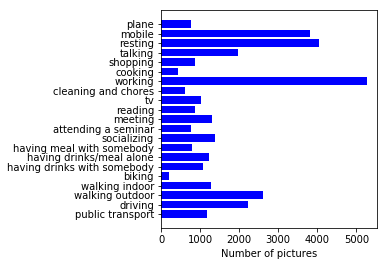

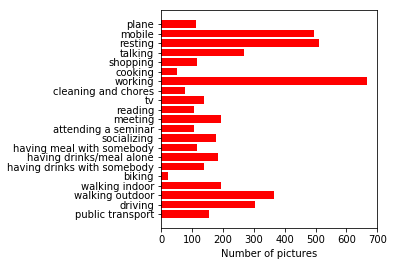

In [5]:
# histogram for number of pictures in each category
def plot_hist(labels, title='', color='blue'):
    plt.gcf().subplots_adjust(left=0.4)
    examples = [0] * NUM_ACTIVITIES_LABELS
    for label in labels:
        examples[label] += 1

    y_pos = np.arange(NUM_ACTIVITIES_LABELS)
    
    plt.barh(y_pos, examples, alpha=1, color=color)
    plt.yticks(y_pos, labels_set)
    plt.xlabel(title)
    plt.show()
    
plot_hist(train_labels, 'Number of pictures', color='blue')
plot_hist(val_labels, 'Number of pictures', color='red')

In [6]:
def store_weights(weights):
    data = open(weights).read()
    with open(activities_net_desc['weights'], 'w') as f:
        f.write(data)
        
def store_solver(solver):
    with open(activities_net_desc['solver'], 'w') as f:
        f.write(solver)

Here we are going to define the solver file, as caffe does not allow us to define the num of epochs we want to train, we are going to define the number of iterations based on the number of epochs we want

In [7]:
# train 10 epochs, which means that we are going to go through the dataset 20 times
num_train = num_train_images
num_val = num_val_images
num_epochs = 10

# batch size 32 takes around 4GB 
# if the model doesn't fit in GPU memory, try to reduce the batch size to 24 
# that needs to be changed in train_val.prototxt too
batch_size = 10
iters_per_epoch = num_train_images / batch_size # iterations for an epoch
iters_per_val = num_val_images / batch_size


### solver data definition
solver_data = {}
solver_data['val_iter'] = iters_per_val  /  5              # iterations for the validation
solver_data['val_interval'] = iters_per_epoch / 2          # validate twice per epoch
solver_data['base_lr'] = 0.000067                          # initial learning rate
solver_data['display_interval'] = solver_data['val_interval'] * 2
solver_data['num_iter'] = num_epochs * iters_per_epoch     # total iterations
solver_data['drop_rate'] = 0.1
solver_data['drop_lr_step'] = 5 * iters_per_epoch          # learning rate will decrease each 5 epochs
solver_data['train_val'] = activities_net_desc['train_val']
solver_data['snapshot_prefix'] = activities_net_desc['snapshot']
solver_data['snapshot'] = 5 * iters_per_epoch
    

#### solver definition
solver_content = """test_iter: %(val_iter)i
test_interval: %(val_interval)i
base_lr: %(base_lr).6f
display: %(display_interval)i
max_iter: %(num_iter)i
lr_policy: "step"
gamma: %(drop_rate).5f
momentum: 0.9
weight_decay: 0.005
stepsize: %(drop_lr_step)i
snapshot: %(snapshot)i
snapshot_prefix: "%(snapshot_prefix)s"
solver_mode: GPU
net: "%(train_val)s"
solver_type: SGD""" % (solver_data)

store_solver(solver_content)

print "This is the solver that is going to be used:"
print solver_content

This is the solver that is going to be used:
test_iter: 90
test_interval: 1687
base_lr: 0.000067
display: 3374
max_iter: 33750
lr_policy: "step"
gamma: 0.10000
momentum: 0.9
weight_decay: 0.005
stepsize: 16875
snapshot: 16875
snapshot_prefix: "models/finetuning-googlenet/three_users/result_snapshot"
solver_mode: GPU
net: "models/finetuning-googlenet/train_val.prototxt"
solver_type: SGD


In [8]:
def run_solvers(niter, solver_data, disp_interval, validation_interval):
    # keep track of the data
    name, s = solver_data
    
    train_types = ('loss1/loss1', 'loss2/loss2', 'loss3/loss3','loss3/top-1')
    val_types = (
        'loss1/loss1', 'loss1/top-1',  'loss1/top-5',
        'loss2/loss2', 'loss2/top-1',  'loss2/top-5',
        'loss3/loss3', 'loss3/top-1',  'loss3/top-5'
    )
    
    train_data = {t:[0] for t in train_types}
    val_data = {t:[0] for t in val_types}
    
    train_iters = [0]
    val_iters = [0]
    
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax2 = ax1.twinx()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    
    a, = ax1.plot(train_iters, train_data['loss3/loss3'], 'blue', label='train loss 3')
    c, = ax1.plot(val_iters, val_data['loss3/loss3'], 'green', label='val loss 3')
    d, = ax2.plot(train_iters, train_data['loss3/top-1'], 'red', label='train accuracy')
    f, = ax2.plot(val_iters, val_data['loss3/top-1'], 'orange', label='val accuracy')
    
    plt.legend(handles=[a, c, d, f],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    for iteration in range(niter):
        s.step(1)  
        
        if iteration % disp_interval == 0 or iteration % validation_interval == 0 :
            train_iters.append(iteration)
            #train_data['loss3/loss3'].append( s.net.blobs['data'].copy() )
            train_data['loss3/loss3'].append( s.net.blobs['loss3/loss3'].data.copy() )
            train_data['loss3/top-1'].append( s.net.blobs['loss3/top-1'].data.copy() )
            ax1.plot(train_iters, train_data['loss3/loss3'], 'blue', label='train loss 3')
            ax2.plot(train_iters, train_data['loss3/top-1'], 'red', label='train accuracy')

            
            if iteration % validation_interval == 0 : # or iteration == niter - 1: # interval step and last step
                val_iters.append(iteration)
                #val_data['loss3/loss3'].append( s.test_nets[0].blobs['data'].copy() )
                #val_data['loss3/top-1'].append( s.test_nets[0].blobs['data'].copy() )
                #val_data['loss3/top-5'].append( s.test_nets[0].blobs['data'].copy() )
                
                val_data['loss3/loss3'].append( s.test_nets[0].blobs['loss3/loss3'].data.copy() )
                val_data['loss3/top-1'].append( s.test_nets[0].blobs['loss3/top-1'].data.copy() )

                ax1.plot(val_iters, val_data['loss3/loss3'], 'green', label='val loss 3')
                ax2.plot(val_iters, val_data['loss3/top-1'], 'orange', label='val accuracy')

                print """
                %i\t\t'train loss3/loss3': %.3f 'val loss3/loss3': %.3f 
                \t\t'train loss3/top-1': %.3f 'val loss3/top-1': %.3f""" % (
                    iteration, train_data['loss3/loss3'][-1], val_data['loss3/loss3'][-1],
                      train_data['loss3/top-1'][-1], val_data['loss3/top-1'][-1])

            fig.canvas.draw()
        
    # save learned weights
    weight_dir = tempfile.mkdtemp()
    
    filename = 'weights.%s.caffemodel' % name
    weights = os.path.join(weight_dir, filename)
    s.net.save(weights)
    
    #return data, weights
    return train_data, val_data, weights

In [ ]:
activities_solver_filename = activities_net_desc['solver']

activities_solver = caffe.get_solver(activities_solver_filename)
activities_solver.net.copy_from(googlenet_weights)

print 'Running solver for %d iterations...' % solver_data['num_iter']

solver_desc = ('finetuning', activities_solver)

init = time.clock()

# run the solver
train_data, val_data, finetuning_weights = run_solvers(
    solver_data['num_iter'], 
    solver_desc, 
    solver_data['display_interval'], 
    solver_data['val_interval']
)

end = time.clock() - init
print "Traning done in %2.f s" %(end)

del activities_solver, solver_desc

store_weights(finetuning_weights)

Running solver for 33750 iterations...
